# Result ID regression

In [7]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import statsmodels.api as sm
import sympy as sp
from sympy import Eq, symbols, latex
import paper
from paper import save_fig, save_eq
import yaml
with open("styles.yml", mode='r') as file:
    styles = yaml.safe_load(file)
from phd.pipelines.predict.nodes import score

In [9]:
#%reload_kedro
ship='wPCC'
ship_data = catalog.load(f"{ship}.ship_data")

df_VCT = catalog.load(f"{ship}.df_VCT")
resistance_MDL = catalog.load(f"{ship}.resistance_MDL")
tests_ek_smooth = catalog.load(f"{ship}.tests_ek_smooth")
tests_ek = catalog.load(f"{ship}.tests_ek")

mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion

time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")
#tests_ek_smooth_joined = catalog.load(f"{ship}.tests_ek_smooth_joined")
tests_ek_joined = catalog.load(f"{ship}.tests_ek_joined")

df_VCT = catalog.load(f"{ship}.df_VCT")
mask = ((df_VCT['Y_R_port'] > 0) & (df_VCT['test type'] == 'self propulsion'))
df_VCT = df_VCT.loc[~mask].copy()  ## remove duplicate self propulsion


[01/15/24 10:42:57] INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=760074;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=935913;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=219485;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=418192;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.resistance_MDL' (CSVDataSet)...            ]8;id=314799;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=266951;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_smooth' (PartitionedDataset)...   ]8;id=503392;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406669;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek' (PartitionedDataset)...          ]8;id=854448;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=716989;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=356254;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=631802;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.tests_ek_joined' (CSVDataSet)...           ]8;id=111548;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=793279;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

[01/15/24 10:42:58] INFO     Loading data from 'wPCC.df_VCT' (CSVDataSet)...                    ]8;id=32488;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=4237;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

## MDL model tests

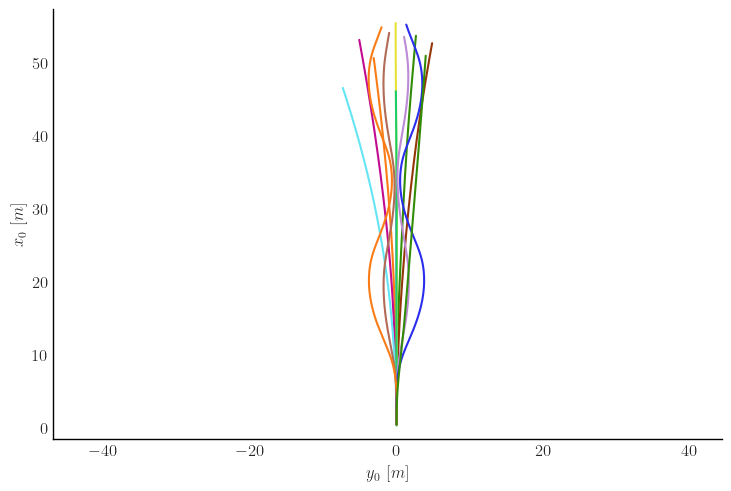

In [90]:
fig,ax=plt.subplots()

mask = tests_ek_joined['id'].isin([
    #22774,  # Circle
    #22611,
    #22635,
    #22639,
    22769,
    22771,
])

tests_ek_smooth_joined = tests_ek_joined.loc[~mask].copy()

for id, group in tests_ek_smooth_joined.groupby(by='id'):
    group[['x0','y0']].rolling(window=100).mean().plot(x='y0',y='x0', label=id, ax=ax)
ax.axis('equal')
ax.get_legend().set_visible(False)
ax.set_xlabel(r'$y_0$ $[m]$')
ax.set_ylabel(r'$x_0$ $[m]$')
fig.savefig(paper.file_path_with_nb_ref("model_tests.pdf"))

In [11]:
loaders = {
        
    'Reference model' : catalog.load(f"{ship}.models_VCT_MDL")['semiempirical_covered'],
    'Physics informed ID' : catalog.load(f"{ship}.models_ID_hull")['semiempirical_covered'],
    
    #'Abkowitz  VCT': catalog.load(f"{ship}.models_rudder_VCT_MDL")['Abkowitz'],
    'Abkowitz ID' : catalog.load(f"{ship}.models_ID_hull_rudder")['Abkowitz'],
}

                    INFO     Loading data from 'wPCC.models_VCT_MDL' (PartitionedDataset)...    ]8;id=256320;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=57098;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull' (PartitionedDataset)...    ]8;id=544615;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=305434;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models_ID_hull_rudder'                     ]8;id=770399;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=641277;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

In [12]:
models = {name:loader() for name,loader in loaders.items()}

## Experiment

In [13]:
#id = 22773
id = 22772
#id = 22770
#id = 22764
#id = 22774
#id = 22616  # Spiral


#data_MDL = tests_ek[f'{id}']()
data_MDL = tests_ek_smooth[f'{id}']()

data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
data_MDL['twa']=0
data_MDL['tws']=0
data_MDL['theta']=0
data_MDL['q']=0
data_MDL['phi'] = data_MDL['roll']
data_MDL['p'] = 0
data_MDL['q1d'] = 0
data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']
data_MDL['beta_deg'] =  np.rad2deg(data_MDL['beta'])

[01/15/24 17:27:29] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=868864;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=321897;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_4367/843651277.py:5: UserWarning: The figure layout has ]8;id=770378;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=216708;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             changed to tight                                                                      
                               plt.tight_layout()                                                                  
                                                                                                                   

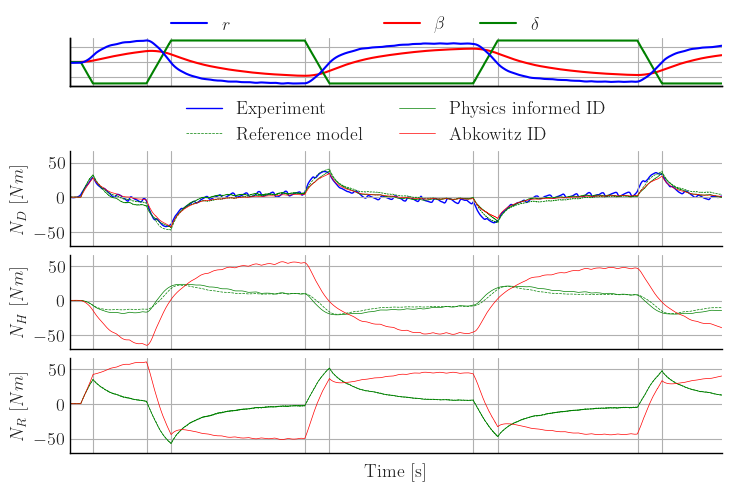

In [97]:
fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data_MDL, styles=styles, keys=['N_D','N_H','N_R'])
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=3)
fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()

fig.savefig(paper.file_path_with_nb_ref("ID_regression_ID_N.pdf"))

[01/15/24 17:27:39] WARNING  /home/maa/dev/PHD/src/phd/visualization/plot_prediction.py:252:        ]8;id=251133;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=960523;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             UserWarning: The figure layout has changed to tight                                   
                               plt.tight_layout()                                                                  
                                                                                                                   

                    WARNING  /tmp/ipykernel_4367/2533793509.py:5: UserWarning: The figure layout    ]8;id=693838;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=209894;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

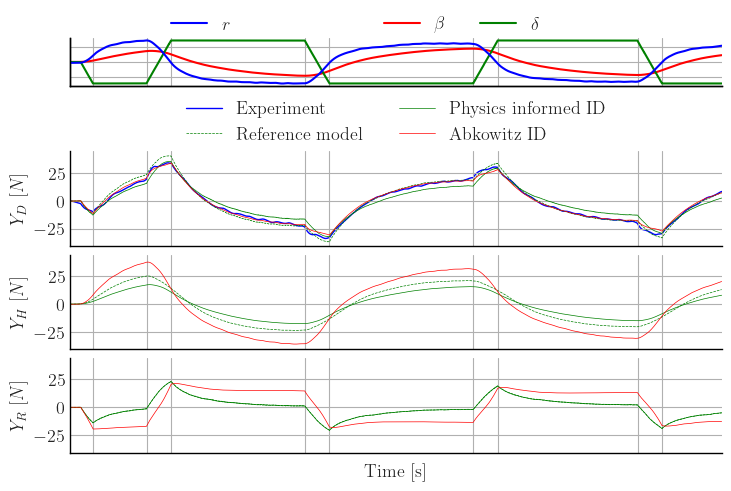

In [98]:
fig = plot_compare_model_forces(model=models['Reference model'], models=models, data=data_MDL, styles=styles, keys=['Y_D','Y_H','Y_R'])
fig.axes[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.8), ncol=3)
fig.axes[4].legend(loc='upper center', bbox_to_anchor=(0.2, 1.8), ncol=1)
fig.axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.7), ncol=2)
plt.tight_layout()
fig.savefig(paper.file_path_with_nb_ref("ID_regression_ID_Y.pdf"))

## Parameter decomposition
The predicted forces can be decomposed into the various parameter contributions. It can be seen that the `model` and `Abkowitz` have very different decompositions, eventhough the simulations results above are similar. The contributions from the Nr and Nrrr coefficients are very large for the `Abkowitz`.

[01/15/24 17:27:55] WARNING  /tmp/ipykernel_4367/133157958.py:21: UserWarning: The figure layout    ]8;id=775410;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=259396;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             has changed to tight                                                                  
                               plt.tight_layout()                                                                  
                                                                                                                   

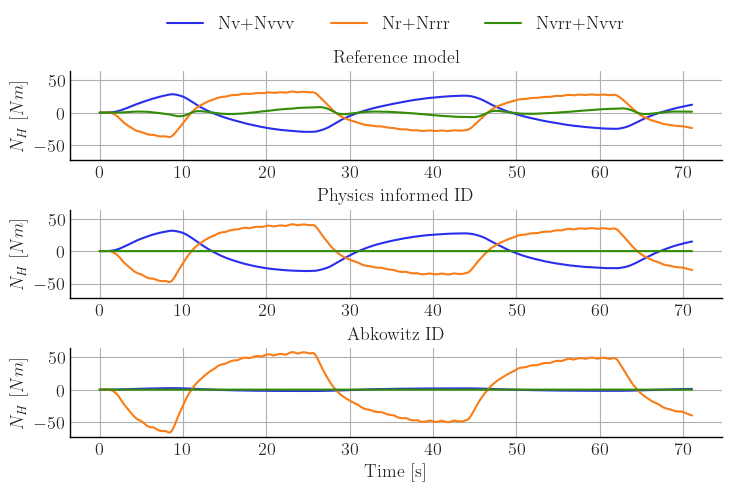

In [99]:
fig,axes=plt.subplots(nrows=len(models))

for ax, (name, model) in zip(axes,models.items()):
                      
    ax.set_title(name)
    plot_parameter_contributions(model=model, data=data_MDL, ax=ax, prefix='N', unit='moment')
    ax.grid(True)

ylims = []
for ax in axes:
    ylims.append(ax.get_ylim())
    
ylims = [np.min(ylims, axis=0)[0],np.max(ylims, axis=0)[1]]
for ax in axes:
    ax.set_ylim(ylims)
    
for ax in axes[1:]:
    ax.get_legend().set_visible(False)

axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.8), ncol=3)
plt.tight_layout()
axes[-1].set_xlabel('Time [s]')

fig.savefig(paper.file_path_with_nb_ref("ID_regression_N_decomposition.pdf"))

## Other tests

In [18]:
score_models = ['Physics informed ID', 'Abkowitz ID']


In [20]:
def preprocess(data_MDL):
    data_MDL['V'] = data_MDL['U'] = np.sqrt(data_MDL['u']**2 + data_MDL['v']**2)
    data_MDL['beta'] = -np.arctan2(data_MDL['v'],data_MDL['u'])
    data_MDL['rev'] = data_MDL[['Prop/PS/Rpm','Prop/SB/Rpm']].mean(axis=1)
    data_MDL['twa']=0
    data_MDL['tws']=0
    data_MDL['theta']=0
    data_MDL['q']=0
    data_MDL['phi'] = data_MDL['roll']
    data_MDL['p'] = 0
    data_MDL['q1d'] = 0
    data_MDL['thrust_port'] = data_MDL['Prop/PS/Thrust']
    data_MDL['thrust_stbd'] = data_MDL['Prop/SB/Thrust']

In [41]:
_ = []
ids = tests_ek_smooth_joined['id'].unique()
for model_name in score_models:
    model = models[model_name]
    
    for id in ids:
        
        loader = tests_ek_smooth[str(id)]
        data = loader()
        preprocess(data)
        try:
            s = score(model=model, data=data)
        except:
            print(f"Skipping {id}")
            continue
        
        s = pd.Series(s, name=id)
        s['model'] = model_name       
        _.append(s)
    
df_scores = pd.DataFrame(_)

[01/15/24 16:23:09] WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/ ]8;id=845748;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=23576;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt                   
                               result = getattr(ufunc, method)(*inputs, **kwargs)                                  
                                                                                                                   

                    WARNING  /home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/pandas/core/ ]8;id=413428;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=592862;file:///home/maa/anaconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt                   
                               result = getattr(ufunc, method)(*inputs, **kwargs)                                  
                                                                                                                   

Skipping 22862


In [42]:
time_series_meta_data = catalog.load(f"{ship}.time_series_meta_data")

[01/15/24 16:23:16] INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=583048;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=559287;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [43]:
steals = [
    'test_type',
    'angle1',
    'ship_speed',
]
for steal in steals:
    df_scores[steal] = time_series_meta_data[steal]

In [47]:
mask = df_scores['test_type'] == 'rodergrundvinkel'
df_scores.loc[mask,'test_type'] = 'yaw rate'

mask = df_scores['test_type'] == 'reference speed'
df_scores.loc[mask,'test_type'] = 'ref. speed'

mask = df_scores['test_type'] == 'zigzag'
df_scores.loc[mask,'Description'] = df_scores.loc[mask].apply(lambda x:f"{x['test_type']}{int(x['angle1'])}/{int(x['angle1'])}", axis=1)
df_scores.loc[~mask,'Description'] = df_scores.loc[~mask,'test_type']
if 'angle1' in df_scores:
    df_scores.drop(columns='angle1',inplace=True)

In [53]:
df_scores

,X_D,Y_D,N_D,model,test_type,ship_speed,Description
22611,1.343990,0.192798,0.533657,Physics informed ID,ref. speed,0.961770,ref. speed
22612,1.256713,0.394075,0.663429,Physics informed ID,yaw rate,0.961770,yaw rate
22613,1.188203,0.437501,0.926382,Physics informed ID,yaw rate,0.961770,yaw rate
22614,1.659596,0.460909,0.592852,Physics informed ID,yaw rate,0.961770,yaw rate
22615,1.316132,0.526920,1.174215,Physics informed ID,yaw rate,0.961770,yaw rate
22616,1.521015,0.718368,0.768911,Physics informed ID,yaw rate,0.961770,yaw rate
22635,5.097192,0.339161,0.510367,Physics informed ID,ref. speed,0.801475,ref. speed
22639,7.382862,0.339240,0.409657,Physics informed ID,ref. speed,0.641180,ref. speed
22764,1.569621,1.823845,1.913523,Physics informed ID,zigzag,0.961770,zigzag10/10
22770,1.602734,1.934547,2.005314,Physics informed ID,zigzag,0.961770,zigzag10/10


Text(0.5, 0, 'Test type')

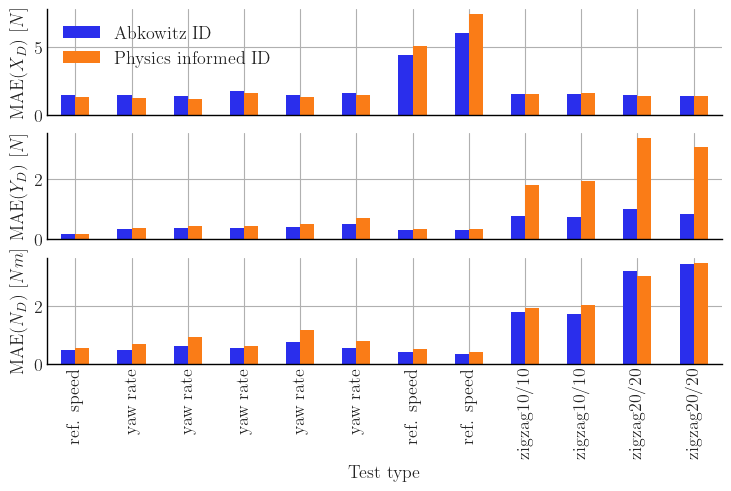

In [100]:
fig,axes=plt.subplots(nrows=3)
dofs = ['X_D','Y_D','N_D']
for dof,ax in zip(dofs,axes):
    df_scores.pivot(columns='model').dropna().plot.bar(x=('Description','Abkowitz ID'), y=dof,ax=ax)

for ax in axes[1:]:
    ax.get_legend().set_visible(False)
    
for ax in axes[0:-1]:
    ax.set_xticklabels([])

for ax in axes:
    ax.set_xlabel('')
    ax.grid(True)
    
axes[0].legend(loc='upper left')
axes[0].set_ylabel(r'MAE($X_D$) $[N]$')
axes[1].set_ylabel(r'MAE($Y_D$) $[N]$')
axes[2].set_ylabel(r'MAE($N_D$) $[Nm]$');
axes[2].set_xlabel('Test type')


In [101]:
fig.savefig(paper.file_path_with_nb_ref("ID_models_mean_average_error.pdf"))